## kode awal

In [ ]:
import pandas as pd
read = pd.read_csv('terjemahandataset.csv')
df = read.iloc[0:100]
df = pd.DataFrame(df, columns=['airline_sentiment', 'text_terjemahan'])
dft = pd.DataFrame(df, columns=['text_terjemahan'])
dft.tail(2)

In [ ]:
import streamlit as st
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize as token_kata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import os

import nltk
nltk.download('punkt')

In [ ]:
import streamlit as st
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize as token_kata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import os

import nltk
nltk.download('punkt')

def ubah_ke_huruf_kecil(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].str.lower()
    return dataframe

# Fungsi untuk menghapus karakte-karakter spesial twitter(X) dari data hasil scrapping
def bersihkan_karakter_twitter(text):
    text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = ' '.join(re.sub(r"([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)", " ", text).split())
    return text.replace("http://", " ").replace("https://", " ")

# Fungsi untuk menghapus angka untuk penyederhanaan data clear
def hapus_angka(text):
    return re.sub(r"\d+", "", text)

# Fungsi untuk menghapus tanda baca seperti titik, koma, tanda seru, dll.
def hapus_tandabaca(text):
    return text.translate(str.maketrans("", "", string.punctuation))

# Fungsi untuk menghapus whitespace atau spasi yang ada di awal dan akhir teks.
def hapus_spasi_awalakhir(text):
    return text.strip()

# Fungsi untuk mengganti spasi berturut turut dengan satu spasi tunggal.
def ganti_spasi_tunggal(text):
    return re.sub(r'\s+', ' ', text)

# Fungsi untuk menghapus karakter tunggal yang berdiri sendiri di dalam teks
def hapus_karakter_tunggal(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

# Fungsi untuk membaca file JSON yang berisi kamus slang (bahasa gaul) dan menyimpannya ke dalam bentuk dictionary
def muat_kamus_slang(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)
    
# Fungsi untuk menggantikan bahasa gaul di dalam teks dengan padanan yang lebih baku berdasarkan kamus slang.
def slang_ke_baku(text, kamus_bahasa_gaul):
    return " ".join(kamus_bahasa_gaul.get(word, word) for word in text.split())

# Stemming
pengolahdata = StemmerFactory() # Digunakan untuk membuat objek stemmer.
stemmer = pengolahdata.create_stemmer() # Membuat objek stemmer yang dapat digunakan untuk melakukan proses stemming.

# Fungsi untuk mengubah teks ke dalam bentuk token
def bungkus_tokenisasi_kata(text):
    return text.split()
# Fungsi untuk mengubah setiap kata ke bentuk dasarnya.
def sederhanakan_teks(tokens):
    # Gabungkan token menjadi string dan lakukan stemming
    return ' '.join([stemmer.stem(token) for token in tokens])



class StopWordsIndo:
    def __init__(self, stopwords_file):
        self.stopwords = self.olah_stopword(stopwords_file)
    
    def olah_stopword(self, stopwords_file):
        with open(stopwords_file, 'r', encoding='utf-8') as f:
            return set(f.read().splitlines())
    
    def hapus_stopwords(self, text):
        pisahkan_kata = text.split()
        kata_bersih = [word for word in pisahkan_kata if word not in self.stopwords and len(word) > 3]
        return " ".join(kata_bersih)
class KamusFilter:
    def __init__(self, kamus_file):
        self.term_dict = self.baca_kamus(kamus_file)

    def baca_kamus(self, kamus_file):
        try:
            with open(kamus_file, 'r', encoding='utf-8') as file:
                return set(file.read().splitlines())
        except FileNotFoundError:
            print(f"File {kamus_file} tidak ditemukan.")
            return set()

    def hapus_bukan_id(self, document):
        return [term for term in document if term in self.term_dict]



# Fungsi untuk memuat leksikon sentimen
def load_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)
    

dft['text_terjemahan'] = ubah_ke_huruf_kecil(dft, 'text_terjemahan')
dft['text_terjemahan'] = dft['text_terjemahan'].apply(bersihkan_karakter_twitter)
dft['text_terjemahan'] = dft['text_terjemahan'].apply(hapus_angka)
dft['text_terjemahan'] = dft['text_terjemahan'].apply(hapus_tandabaca)
dft['text_terjemahan'] = dft['text_terjemahan'].apply(hapus_spasi_awalakhir)
dft['text_terjemahan'] = dft['text_terjemahan'].apply(ganti_spasi_tunggal)
dft['text_terjemahan'] = dft['text_terjemahan'].apply(hapus_karakter_tunggal)

# Load dan replace slang
kamus_bahasa_gaul = muat_kamus_slang("txt/kamusSlang.json")
dft['text_terjemahan'] = dft['text_terjemahan'].apply(lambda x: slang_ke_baku(x, kamus_bahasa_gaul))

# Tokenisasi
dft['text_terjemahan'] = dft['text_terjemahan'].apply(bungkus_tokenisasi_kata)

# Stemming
dft['text_terjemahan'] = dft['text_terjemahan'].apply(sederhanakan_teks)

# Inisialisasi stopword dan kamus filter
stopwords_processor = StopWordsIndo('txt/stopwords.txt')
kamus_filter = KamusFilter("txt/kamusIndonesia.txt")

# Hapus stopword
dft['stopwords'] = dft['text_terjemahan'].apply(lambda x: stopwords_processor.hapus_stopwords(x))

# Filter term non-indonesia
dft['filtered'] = dft['stopwords'].apply(lambda x: kamus_filter.hapus_bukan_id(x.split()))

# Load leksikon positif dan negatif
pos_lexicon = load_lexicon('leksikon/leksikon-pos.json')
neg_lexicon = load_lexicon('leksikon/leksikon-neg.json')

def hitung_sentimen_berdasarkan_leksikon(text):
    if not isinstance(text, str):
        text = ""
    pos_count = sum(1 for word in text.split() if word in pos_lexicon)
    neg_count = sum(1 for word in text.split() if word in neg_lexicon)
    if pos_count > neg_count:
        return 'Positif', 1  # Sentimen positif dan skor
    elif neg_count > pos_count:
        return 'Negatif', -1  # Sentimen negatif dan skor
    else:
        return 'Netral', 0  # Sentimen netral dan skor
    

In [ ]:
dft.head(10)

# DATASET TERJEMAHANDATASET.CSV

In [ ]:
import streamlit as st
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize as token_kata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')

# Fungsi preprocessing
pengolahdata = StemmerFactory()
stemmer = pengolahdata.create_stemmer()

def preprocessing(text, slang_dict, stopwords, kamus_indonesia):
    text = text.lower()
    text = re.sub(r"\\t|\\n|\\u|\\|http[s]?://\\S+|[@#][A-Za-z0-9_]+", " ", text)
    text = re.sub(r"\\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus karakter selain huruf dan spasi
    text = re.sub(r"\\s+", ' ', text).strip()  # Menghapus whitespace tambahan
    text = ' '.join([slang_dict.get(word, word) for word in text.split()])
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopwords and len(word) > 3 and word in kamus_indonesia])
    return text

# Muat data
def load_data():
    df = pd.read_csv('terjemahandataset.csv').iloc[0:100]
    return pd.DataFrame(df, columns=['airline_sentiment', 'text_terjemahan'])

def load_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(json.load(file))

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(file.read().splitlines())

def hitung_sentimen(text, pos_lexicon, neg_lexicon):
    pos_count = sum(1 for word in text.split() if word in pos_lexicon)
    neg_count = sum(1 for word in text.split() if word in neg_lexicon)
    if pos_count > neg_count:
        return 'positive', 1
    elif neg_count > pos_count:
        return 'negative', -1
    else:
        return 'neutral', 0



# Muat sumber daya
slang_dict = json.load(open("txt/kamusSlang.json", "r", encoding="utf-8"))
stopwords = load_file('txt/stopwords.txt')
kamus_indonesia = load_file('txt/kamusIndonesia.txt')
pos_lexicon = load_lexicon('leksikon/leksikon-pos.json')
neg_lexicon = load_lexicon('leksikon/leksikon-neg.json')

# Proses data
df = load_data()
df['ulasan'] = df['text_terjemahan'].apply(lambda x: preprocessing(x, slang_dict, stopwords, kamus_indonesia))

# Hapus baris yang memiliki nilai kosong (termasuk yang berisi spasi atau karakter non-huruf)
df = df[df['ulasan'].str.strip().astype(bool)]  # Hanya baris yang tidak kosong setelah strip dan konversi ke bool

# Lanjutkan dengan analisis
df[['prediksi', 'prediksi-skor']] = df['ulasan'].apply(lambda x: pd.Series(hitung_sentimen(x, pos_lexicon, neg_lexicon)))

accuracy = (df['airline_sentiment'] == df['prediksi']).mean()
print(f"Akurasinya: {accuracy * 100:.2f}%")

In [ ]:
df.head(50)

# DATASET GLASSDOOR

In [ ]:
# df = pd.read_csv("glassdoor_reviews/uji-klasifikasi-sentimen-100.csv")
# df.head(2)

In [1]:
import streamlit as st
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')

# Fungsi preprocessing
pengolahdata = StemmerFactory()
stemmer = pengolahdata.create_stemmer()

# def preprocessing(text, slang_dict, stopwords, kamus_indonesia):
#     text = text.lower()
#     text = re.sub(r"\\t|\\n|\\u|\\|http[s]?://\\S+|[@#][A-Za-z0-9_]+", " ", text)
#     text = re.sub(r"\\d+", "", text)
#     text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca
#     text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus karakter selain huruf dan spasi
#     text = re.sub(r"\\s+", ' ', text).strip()  # Menghapus whitespace tambahan
#     text = ' '.join([slang_dict.get(word, word) for word in text.split()])
#     text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopwords and len(word) > 3 and word in kamus_indonesia])
#     return text
def preprocessing(text, slang_dict, stopwords, kamus_indonesia):
    text = text.lower()  # Case folding
    text = re.sub(r"\\t|\\n|\\u|\\|http[s]?://\\S+|[@#][A-Za-z0-9_]+", " ", text)  # Menghapus karakter khusus
    text = re.sub(r"\\d+", "", text)  # Menghapus angka
    text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca (pakai import string)
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus karakter selain huruf dan spasi
    text = re.sub(r"\b[a-zA-Z]\b", "", text) # Menghapus satu huruf (besar/kecil)
    text = re.sub(r"\\s+", ' ', text).strip()  # Menghapus spasi ganda
    text = ' '.join([slang_dict.get(word, word) for word in text.split()]) # Normalisasi (pakai kamus slang)
    text = word_tokenize(text) # Tokenisasi (sebelum stemming)
    text = ' '.join([stemmer.stem(word) for word in text if word not in stopwords and len(word) > 3 and word in kamus_indonesia]) # Stemming, stopwords dan filter
    return text

# Muat data
def load_data():
    df = pd.read_csv('csv/uji-klasifikasi-sentimen.csv') #.iloc[0:100]
    return pd.DataFrame(df)

def load_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(json.load(file))

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(file.read().splitlines())

def hitung_sentimen(text, pos_lexicon, neg_lexicon):
    pos_count = sum(1 for word in text.split() if word in pos_lexicon)
    neg_count = sum(1 for word in text.split() if word in neg_lexicon)
    if pos_count > neg_count:
        return 'Positif', 1
    elif neg_count > pos_count:
        return 'Negatif', -1
    else:
        return 'Netral', 0





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Muat sumber daya
slang_dict = json.load(open("txt/kamusSlang.json", "r", encoding="utf-8"))
stopwords = load_file('txt/stopwords.txt')
kamus_indonesia = load_file('txt/kamusIndonesia.txt')
pos_lexicon = load_lexicon('leksikon/leksikon-pos.json')
neg_lexicon = load_lexicon('leksikon/leksikon-neg.json')

# Proses data
df = load_data()
df = df.dropna(subset=['sentimen'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1678 non-null   object
 1   ulasan    1678 non-null   object
dtypes: object(2)
memory usage: 26.3+ KB


In [3]:

df['ulasan'] = df['ulasan'].apply(lambda x: preprocessing(x, slang_dict, stopwords, kamus_indonesia))

# Hapus baris yang memiliki nilai kosong (termasuk yang berisi spasi atau karakter non-huruf)
df = df[df['ulasan'].str.strip().astype(bool)] 

# Lanjutkan dengan analisis
df[['prediksi', 'prediksi-skor']] = df['ulasan'].apply(lambda x: pd.Series(hitung_sentimen(x, pos_lexicon, neg_lexicon)))

accuracy = (df['sentimen'] == df['prediksi']).mean()
print(f"Akurasinya: {accuracy * 100:.2f}%")

Akurasinya: 50.90%


In [4]:
df.tail()

,sentimen,ulasan,prediksi,prediksi-skor
1673,Positif,mahasiswa manajemen fleksibel bantu toko rumah...,Positif,0
1674,Negatif,dasar dasar inti lupa rekan,Positif,0
1675,Positif,kolega main upah toko lokal dekat bagus,Positif,0
1676,Positif,anggota staf ramah bantu temu produk makan pakai,Positif,1
1677,Negatif,senjang gaji zona manajemen tingkat rekan reka...,Positif,1


In [8]:
look = pd.read_csv('csv/new_df-ada-netral.csv')
look.head(100)

,firm,recommend,review
0,AFH-Wealth-Management,Negatif,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,Negatif,Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,Negatif,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,Negatif,No career progression and salary is poor
4,AFH-Wealth-Management,Negatif,"Abysmal pay, around minimum wage. No actual tr..."
...,...,...,...
95,AJ-Bell,Positif,Great offices and benefits on offer.\r\nGreat ...
96,AJ-Bell,Negatif,- Soul-less working environment\r\n- Inconveni...
97,AJ-Bell,Positif,"Great working atmosphere, lots of chance for p..."
98,AJ-Bell,Negatif,Too many to list. \r\nHR is biased and sides w...


# DATASET SENTIMEN TWITTER

In [25]:
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocessing(text, slang_dict, stopwords, kamus_indonesia, stemmer):
    text = text.lower()  # Case folding
    text = re.sub(r"\\t|\\n|\\u|\\|http[s]?://\\S+|[@#][A-Za-z0-9_]+", " ", text)  # Menghapus karakter khusus
    text = re.sub(r"\\d+", "", text)  # Menghapus angka
    text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca (pakai import string)
    text = re.sub(r"\\s+", ' ', text).strip()  # merapihkan spasi ganda
    text = re.sub(r"\b[a-zA-Z]\b", "", text) # Menghapus satu huruf (besar/kecil)
    text = ' '.join([slang_dict.get(word, word) for word in text.split()]) # Normalisasi (pemanfaatan kamus slang)
    text = word_tokenize(text) # Tokenisasi (sebelum stemming)
    text = [stemmer.stem(word) for word in text] # Stemming
    text = [word for word in text if word not in stopwords and len(word) > 3 and word in kamus_indonesia] # Stopwords & memilah kata
    text = ' '.join(text)
    return text


# Muat data
def load_data():
    df = pd.read_csv('../csv/dataset-metrik.csv') #.iloc[0:100]
    return pd.DataFrame(df)

def load_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(json.load(file))

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(file.read().splitlines())

def hitung_sentimen(text, pos_lexicon, neg_lexicon):
    pos_count = sum(1 for word in text.split() if word in pos_lexicon)
    neg_count = sum(1 for word in text.split() if word in neg_lexicon)
    if pos_count > neg_count:
        return 'Positif', 1
    elif neg_count > pos_count:
        return 'Negatif', -1
    else:
        return 'Netral', 0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
df = load_data()
df.head()

,label,teks
0,Negatif,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,Negatif,Geblek lo tata...cowo bgt dibela2in balikan......
2,Negatif,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,Negatif,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,Negatif,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [27]:
# Muat sumber daya


# Proses data
df = load_data()
# df = df.dropna(subset=['terjemahan'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   400 non-null    object
 1   teks    400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


In [28]:

df['teks'] = df['teks'].apply(lambda x: preprocessing(x, slang_dict, stopwords, kamus_indonesia,stemmer))

# Hapus baris yang memiliki nilai kosong (termasuk yang berisi spasi atau karakter non-huruf)
df = df[df['teks'].str.strip().astype(bool)] 

# Lanjutkan dengan analisis
df[['prediksi', 'prediksi-skor']] = df['teks'].apply(lambda x: pd.Series(hitung_sentimen(x, pos_lexicon, neg_lexicon)))

accuracy = (df['label'] == df['prediksi']).mean()
print(f"Akurasinya: {accuracy * 100:.2f}%")

Akurasinya: 60.20%


In [30]:
df.iloc[100:150]

,label,teks,prediksi,prediksi-skor
100,Negatif,malu omong pelakor ibuk pelakor pelakor awas r...,Negatif,-1
101,Negatif,kerdus mulut sampah makan,Negatif,-1
102,Negatif,tahi bagus pupuk bacot goblok cewek bawa suku,Negatif,-1
103,Negatif,artis papan belagu artis populer,Positif,1
104,Negatif,anang muka kayak,Negatif,-1
105,Negatif,suka ting ting parah hati otak manusia enak or...,Negatif,-1
106,Negatif,panggil munafik ceramah orang laku istri polig...,Negatif,-1
107,Negatif,biadab anak,Negatif,-1
108,Negatif,dasar anjing cowok orang berani cowok lemah da...,Negatif,-1
109,Negatif,kasihan micin produk micin iklan masak micin b...,Positif,1


Akurasi 60.20%
Confusion Matrix:
         Positif  Negatif  Netral
Positif      121       43      34
Negatif       46      118      35
Netral         0        0       0


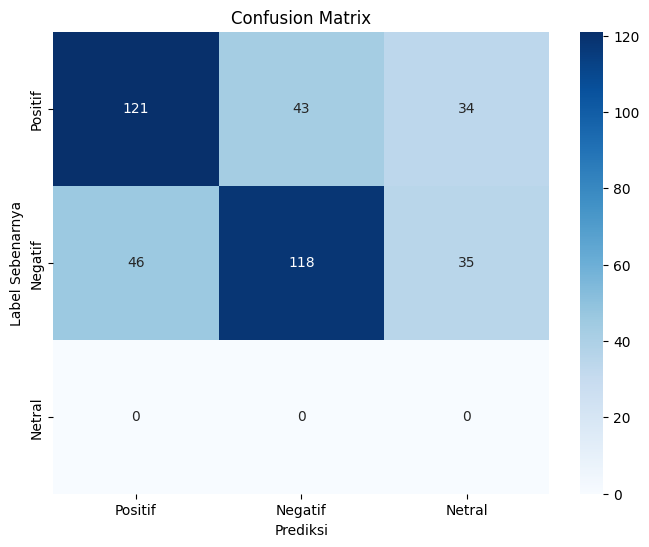

In [32]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 2. Ambil kolom yang diperlukan
y_true = df['label']  # Label sebenarnya
y_pred = df['prediksi']          # Label prediksi

# 3. Hitung confusion matrix
labels = ['Positif', 'Negatif', 'Netral']  # Label yang mungkin
cm = confusion_matrix(y_true, y_pred, labels=labels)
print(f"Akurasi {accuracy * 100:.2f}%")
# 4. Tampilkan confusion matrix dalam tabel
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:")
print(cm_df)

# 5. Visualisasikan confusion matrix (Opsional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()
